<center><h2>车牌区域检测</h2></center>
何长鸿--2016141482154


### 特点：
1. 对于canon和iPhone等数据集有较好的检测效果，精度分别达到100%与95%
1. 可以识别出一张图片中的多个车牌
1. 使用旋转的粉色矩形框精确标记，方便截取出车牌区域做进一步空间变换
1. 基于OpenCV-Python
1. 综合使用颜色空间变换、滤波、形态学变换、模式识别等方法

### 需要改进:
1. 对夜间拍摄的低质量图像识别效果较差，需要进一步优化，在同样参数下hp数据集几乎无法识别

In [1]:
import cv2,json,os
import matplotlib.pyplot as plt
import numpy as np
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 10.0)

### 读取数据集文件名

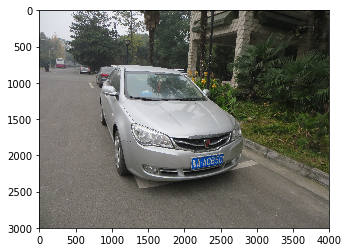

In [37]:
iphone = ['./iPhone/'+f for f in os.listdir('./iPhone/')]
canon = ['./canon/'+f for f in os.listdir('./canon/')]
hp = ['./hp/'+f for f in os.listdir('./hp/')]
img = cv2.imread(canon[6])

bgr = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
plt.imshow(bgr)

### 将图像转为HLS颜色空间

In [38]:
def tohls(img):
    return cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
hls = tohls(img)

### 利用HLS的分量特征，筛选出蓝色和黄色区域，两者逻辑或运算后作为车牌备选区域，并显示筛选出的二值图

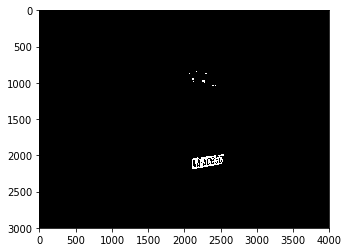

In [39]:
def color_select(hls):
    mask1 = cv2.inRange(hls,np.array([5,15,100]),np.array([14,180,255])) # 蓝色车牌
    mask2 = cv2.inRange(hls,np.array([96,80,140]),np.array([102,180,255])) # 黄色车牌
    mask = cv2.bitwise_or(mask1,mask2)
    return mask
mask = color_select(hls)
plt.imshow(mask,cmap='gray')

### 中值滤波去掉一些较小的8-连通域（噪声）

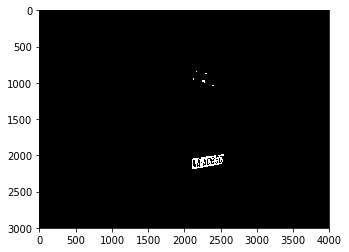

In [40]:
def optimizer(mask):
    pure = cv2.medianBlur(mask,7)
    return pure
pure = optimizer(mask)
plt.imshow(pure,cmap='gray')


### 再使用形态学开运算，使车牌与其他区域分离（在同色背景和车辆情况下有效）
### !!! 考虑车牌形状特点，膨胀时在X方向上使用更大的膨胀系数

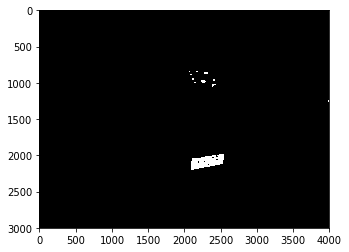

In [41]:
def toErode(img):
    erode = cv2.erode(img,np.ones((5,5)))
    big = cv2.dilate(erode,np.ones((11,19)))
    return big
erode = toErode(pure)
plt.imshow(erode,'gray')

### 提取车牌的矩形框，根据长宽比阈值筛选出可能的区域，并在原图上绘制出所有可能的矩形区域

In [42]:
def isPlate(points):
    ## 根据矩形坐标判断是否为车牌
    x,y,z,w = points
    a = np.sqrt(sum(np.square(x-y)))
    b = np.sqrt(sum(np.square(x-z)))
    c = np.sqrt(sum(np.square(x-w)))
    lengths = [a,b,c]
    lengths.sort()
    rate = lengths[0]/lengths[1]
    print(lengths,rate)
    if  rate< 0.5 and  rate > 0.20:
        
        return True
    return False

### 提取每个连通域的边界，并求其最小邻接矩形,去掉边界点数小于阈值的边界（噪声干扰）

In [43]:
def getRegion(img):
    pure, outer ,a= cv2.findContours(img,mode=cv2.RETR_EXTERNAL,method=cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    for o in outer:
        if len(o) < 60:
            continue
        rect = cv2.minAreaRect(o) #获取最小邻接矩形
        points = np.int0(cv2.boxPoints(rect)) #获取矩形四点坐标
        if isPlate(points):
            boxes.append(points)
    return boxes



### 根据四个顶点坐标在原图上绘制粉色矩形框

In [44]:
def markRegion(img, points):
    # 绘制矩形
    for box in points:
        img = cv2.drawContours(img,[box],-1,(255,0,255),30)
    return img

[155.7080601638849, 481.2660386937769, 506.2459876384207] 0.3235384333091491


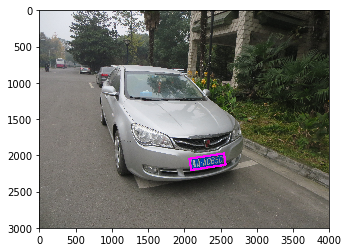

In [45]:
points = getRegion(erode)
img = markRegion(bgr,points)
plt.imshow(img)


### 批量处理保存到finish文件夹下

In [34]:
def batch(file_list):
    for f_name in file_list:
        try:
            img = cv2.imread(f_name)
            hls = tohls(img)
            mask = color_select(hls)
            pure = optimizer(mask)
            erode = toErode(pure)
            points = getRegion(erode)
            img = markRegion(img,points)
            cv2.imwrite('./finish/hp/show_'+f_name.split('/')[-1], img)
        except:
            pass

In [46]:
batch(hp)

[56.32051136131489, 76.53103945458993, 94.847245611035] 0.7359172404124074
[71.56814934033156, 95.75489543621255, 119.55333537798099] 0.7474098218613473
[170.30854353202602, 477.31017169132275, 506.0088932024812] 0.3568089549161438
[248.0, 893.0, 926.7971730643119] 0.2777155655095185
[81.0, 317.0, 327.1849629796577] 0.2555205047318612
[46.2709412050371, 109.65856099730654, 119.07980517283357] 0.42195466349566285
[67.0, 101.0, 121.2023102090055] 0.6633663366336634
[69.0, 72.0, 99.72462083156798] 0.9583333333333334
